In [1]:
import random
import pandas as pd
import numpy as np
import awkward as ak
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplhep as hep
import boost_histogram as bh
import json
from sklearn.metrics import classification_report, roc_auc_score
from scipy import interpolate
from sklearn.metrics import roc_curve, auc
from cycler import cycler
import os

import uproot ## means uproot4
import sklearn.metrics as m

use_helvet = False ## true: use helvetica for plots, make sure the system have the font installed
if use_helvet:
    CMShelvet = hep.style.CMS
    CMShelvet['font.sans-serif'] = ['Helvetica', 'Arial']
    plt.style.use(CMShelvet)
else:
    plt.style.use(hep.style.CMS)

In [2]:
CustNanoData = {
    # 'SingleMuon': "/data/bond/lyazj/Tree/V0/Merged/2018/Data/Tree_SingleMuon_*.root",
    # 'QCD': "/data/bond/lyazj/Tree/V0/Merged/2018/MC/Tree_QCD.root",
    'SingleMuon': "/home/pku/lyazj/Tree_SingleMuon_*.root",
    'QCD': "/home/pku/lyazj/Tree_QCD.root",
}
events = { }
for typefile in CustNanoData:
    events[typefile] = uproot.lazy({CustNanoData[typefile]: "PKUTree"}) ## lazy means lazy computation style
    # for var in ak_arrays.fields:
    #     if "HLT" in var or "FatJet" in var:
    #         events[year][var] = ak_arrays[var]

'texgyreheros-bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-italic.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


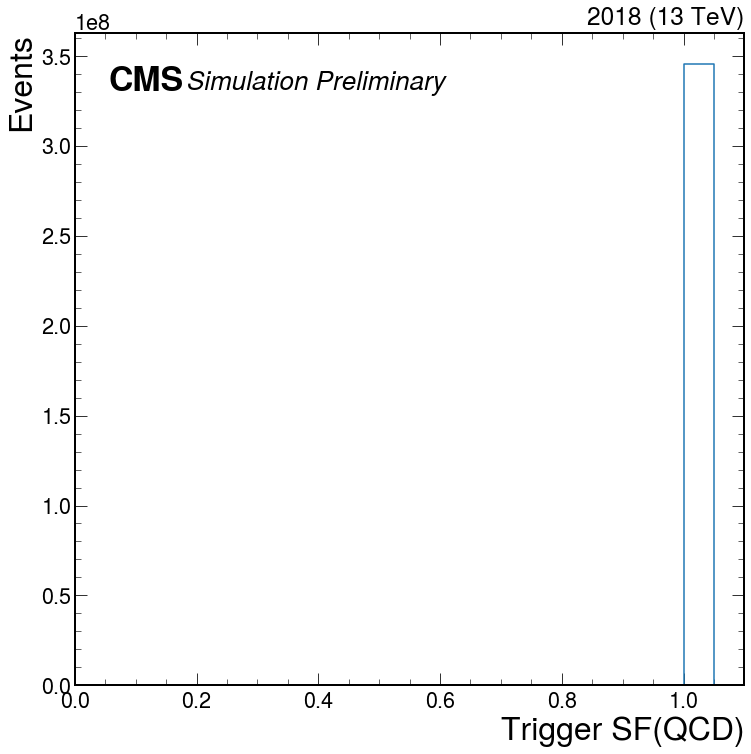

In [7]:
SFbins, SFmin, SFmax = 20, 0.05, 1.05
plt.figure(figsize=(12,12))
ax=plt.gca()
try:
    hep.cms.label(data=False, paper=False, supplementary=False, year=2018, ax=ax, fontname='sans-serif', loc=1)
except Exception:
    hep.cms.label(data=False, label='Preliminary', year=2018, ax=ax, fontname='sans-serif', loc=1)
hist1DSF = bh.Histogram(bh.axis.Regular(SFbins, SFmin, SFmax),storage=bh.storage.Weight())
eventsCut = events["QCD"][events["QCD"]["TriggerSF"] > 0.3]
hist1DSF.fill(eventsCut["TriggerSF"],weight = eventsCut["weight"])
h, err = hist1DSF.view().value, np.sqrt(hist1DSF.view().variance)
hep.histplot(h, bins=hist1DSF.axes[0].edges, yerr=err, histtype='step', stack=False)
plt.xlabel(r"Trigger SF(QCD)", fontsize=32, ha='right', x=1)
plt.ylabel(r"Events", fontsize=32, ha='right', y=1)
plt.savefig("2018QCDTriggerSF.pdf", bbox_inches='tight')
plt.show()

In [8]:
# Plot 2D trigger efficiency SFs uncertainty.
def SF2DUnc_withvalue(eventsMC,eventsData, x_label, y_label, isData = True, xmin = 200, xmax = 1200, bins = 500, legend_location='best'):
    if x_label == y_label: return
    """
    events: a dictionary, events.values() are collections of events
    """
    x_score, y_score = 'score_'+x_label, 'score_'+y_label
    plt.figure(figsize=(15,12))
    ax=plt.gca()
    try:
        hep.cms.label(data=isData, paper=False, supplementary=False, year=2018, ax=ax, fontname='sans-serif')
    except Exception:
        hep.cms.label(data=isData, label='Preliminary', year=2018, ax=ax, fontname='sans-serif')
    mmin = 40.0
    mmax = 240.0
    mbins = 20

    ptmin = 200.0
    ptmax = 600.0
    ptbins = 20
    
    hist2DMC = bh.Histogram(bh.axis.Regular(mbins, mmin, mmax),bh.axis.Regular(ptbins, ptmin, ptmax),storage=bh.storage.Weight())
    hist2DMC.fill(eventsMC["Mj_V2_a"],eventsMC["PTj_V2_a"],weight = eventsMC["weight"])

    eventsMC_Cut = eventsMC[ (eventsMC["HLT_PFJet500"] == True) | (eventsMC["HLT_AK8PFJet500"] == True) | (eventsMC["HLT_AK8PFJet360_TrimMass30"] == True) | (eventsMC["HLT_PFHT1050"] == True) | (eventsMC["HLT_AK8PFJet380_TrimMass30"] == True) | (eventsMC["HLT_AK8PFJet400_TrimMass30"] == True) | (eventsMC["HLT_AK8PFJet420_TrimMass30"] == True) | (eventsMC["HLT_AK8PFHT750_TrimMass50"] == True) | (eventsMC["HLT_AK8PFHT800_TrimMass50"] == True) | (eventsMC["HLT_AK8PFHT850_TrimMass50"] == True) | (eventsMC["HLT_AK8PFHT900_TrimMass50"] == True)]
    
    hist2DMC_Cut = bh.Histogram(bh.axis.Regular(mbins, mmin, mmax),bh.axis.Regular(ptbins, ptmin, ptmax),storage=bh.storage.Weight())
    hist2DMC_Cut.fill(eventsMC_Cut["Mj_V2_a"],eventsMC_Cut["PTj_V2_a"],weight = eventsMC_Cut["weight"]*eventsMC_Cut["TriggerSF"])

    EffiMC2D = hist2DMC_Cut.view().value / hist2DMC.view().value



    hist2DData = bh.Histogram(bh.axis.Regular(mbins, mmin, mmax),bh.axis.Regular(ptbins, ptmin, ptmax),storage=bh.storage.Weight())
    hist2DData.fill(eventsData["Mj_V2_a"],eventsData["PTj_V2_a"])

    eventsData_Cut = eventsData[ (eventsData["HLT_PFJet500"] == True) | (eventsData["HLT_AK8PFJet500"] == True) | (eventsData["HLT_AK8PFJet360_TrimMass30"] == True) | (eventsData["HLT_PFHT1050"] == True) | (eventsData["HLT_AK8PFJet380_TrimMass30"] == True) | (eventsData["HLT_AK8PFJet400_TrimMass30"] == True) | (eventsData["HLT_AK8PFJet420_TrimMass30"] == True) | (eventsData["HLT_AK8PFHT750_TrimMass50"] == True) | (eventsData["HLT_AK8PFHT800_TrimMass50"] == True) | (eventsData["HLT_AK8PFHT850_TrimMass50"] == True) | (eventsData["HLT_AK8PFHT900_TrimMass50"] == True)]
    
    hist2DData_Cut = bh.Histogram(bh.axis.Regular(mbins, mmin, mmax),bh.axis.Regular(ptbins, ptmin, ptmax),storage=bh.storage.Weight())
    hist2DData_Cut.fill(eventsData_Cut["Mj_V2_a"],eventsData_Cut["PTj_V2_a"])

    EffiData2D = hist2DData_Cut.view().value / hist2DData.view().value


    Effi2DSF = EffiData2D/EffiMC2D

    #Start to calculate the uncentainty.
    Invera = 1./hist2DData_Cut.view().value
    Inverc = 1./hist2DData.view().value
    Inverb = 1./hist2DMC.view().value
    Inverd = 1./hist2DMC_Cut.view().value
    Sa = hist2DData_Cut.view().variance
    Sc = hist2DData.view().variance
    Sb = hist2DMC.view().variance
    Sd = hist2DMC_Cut.view().variance
                
    RelaUnc = np.sqrt( (Invera**2) * Sa + (Inverb**2) * Sb + (Inverc**2) * Sc + (Inverd**2) * Sd )
    Unc = Effi2DSF * RelaUnc

    #define mesh
    mesh = ax.pcolormesh(*hist2DMC.axes.edges.T, Unc.T , vmin = 0, vmax = 1 )
    xedges = hist2DMC.axes[0].edges
    # print(xedges)
    yedges = hist2DMC.axes[1].edges
    # print(yedges)
    h = Unc
    # print(h)
    meshed_value = []
    for i in range(len(xedges)-1):
        for j in range(len(yedges)-1):
            print("When mass = ",xedges[i]," pT = ", yedges[j],"SF = ",h[i,j])
            if h[i,j] >= 0 and h[i,j] <= 5: 
                SFij = h[i,j] 
            else : SFij = 1
            dict_tmp = {
                "mass":xedges[i],
                "pT"  :yedges[j],
                "SF"  :SFij
                }
            meshed_value.append(dict_tmp)
            # print(h[i,j])
            plt.text(xedges[i]+0.5*(xedges[i+1]-xedges[i]), yedges[j]+0.5*(yedges[j+1]-yedges[j]), round(h[i,j],2), color='white', ha='center', va='center',fontsize = 14)
    with open('mesh_data_2018_unc.json', 'w') as json_file:
        json.dump(meshed_value, json_file)
    cbar = plt.colorbar(mesh)
    cbar.set_label('Trigger efficiency scale factor uncertainty', rotation= 90,fontsize=32)
    # plt.title('Trigger efficiency scale factor', fontsize=32,color="black", x = 0.3, y = 0.9)

    plt.xlabel(r"Wcb candidate jet $m_{SD}$", fontsize=32, ha='right', x=1)
    plt.ylabel(r"Wcb candidate jet $p_{T}$", fontsize=32, ha='right', y=1)
    plt.savefig("2018Unc" + y_label + "_vs_" + x_label + "TriggerEffiSF.pdf", bbox_inches='tight')

    plt.show()

/home/pku/lyazj/.local/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/pku/lyazj/.local/lib/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in true_divide
/home/pku/lyazj/.local/lib/python3.6/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide
/home/pku/lyazj/.local/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
/home/pku/lyazj/.local/lib/python3.6/site-packages/ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in true_divide
/home/pku/lyazj/.local/lib/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in true_divide
/home/pku/lyazj/.local/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/home/pku/lyazj/.local/lib/python3.6/site-packages/ipykern

When mass =  40.0  pT =  200.0 SF =  0.013592293482727577
When mass =  40.0  pT =  220.0 SF =  0.013508591036266069
When mass =  40.0  pT =  240.0 SF =  0.015233486396565486
When mass =  40.0  pT =  260.0 SF =  0.017526517006829938
When mass =  40.0  pT =  280.0 SF =  0.018656789870519674
When mass =  40.0  pT =  300.0 SF =  0.018819719919987488
When mass =  40.0  pT =  320.0 SF =  0.016188329092806715
When mass =  40.0  pT =  340.0 SF =  0.012461917868945125
When mass =  40.0  pT =  360.0 SF =  0.008639415554995986
When mass =  40.0  pT =  380.0 SF =  0.0062391183362181584
When mass =  40.0  pT =  400.0 SF =  0.006376176635201977
When mass =  40.0  pT =  420.0 SF =  0.008759771377735683
When mass =  40.0  pT =  440.0 SF =  0.012073665307269008
When mass =  40.0  pT =  460.0 SF =  0.014711162989863863
When mass =  40.0  pT =  480.0 SF =  0.016805180582444634
When mass =  40.0  pT =  500.0 SF =  0.018666487574206816
When mass =  40.0  pT =  520.0 SF =  0.02033386884673274
When mass =  4

When mass =  160.0  pT =  400.0 SF =  0.012363934956450991
When mass =  160.0  pT =  420.0 SF =  0.01416907006064948
When mass =  160.0  pT =  440.0 SF =  0.018242598333606315
When mass =  160.0  pT =  460.0 SF =  0.021230016163648783
When mass =  160.0  pT =  480.0 SF =  0.02396313870286268
When mass =  160.0  pT =  500.0 SF =  0.026180572020162374
When mass =  160.0  pT =  520.0 SF =  0.02893055299755299
When mass =  160.0  pT =  540.0 SF =  0.030984049103907927
When mass =  160.0  pT =  560.0 SF =  0.03376389342137891
When mass =  160.0  pT =  580.0 SF =  0.036351698112975464
When mass =  170.0  pT =  200.0 SF =  nan
When mass =  170.0  pT =  220.0 SF =  1.5841325462970468
When mass =  170.0  pT =  240.0 SF =  nan
When mass =  170.0  pT =  260.0 SF =  127.4589918849761
When mass =  170.0  pT =  280.0 SF =  2.2513253605199712
When mass =  170.0  pT =  300.0 SF =  0.4326592700213027
When mass =  170.0  pT =  320.0 SF =  0.1818565258377297
When mass =  170.0  pT =  340.0 SF =  0.085021

'texgyreheros-bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-italic.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


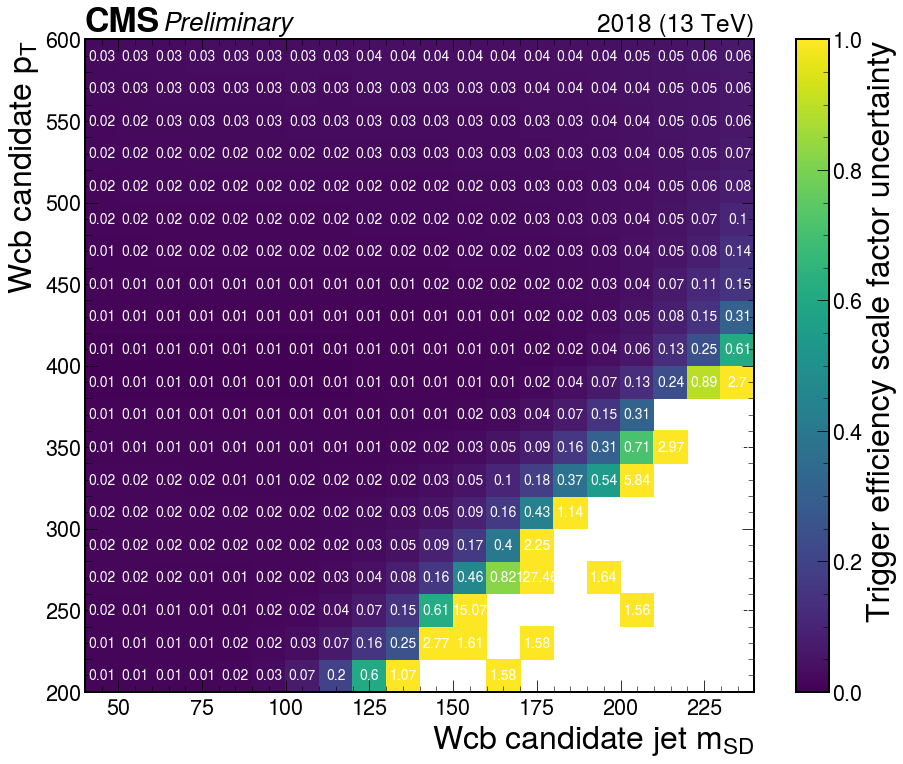

In [9]:
SF2DUnc_withvalue(eventsMC=events["QCD"], eventsData=events["SingleMuon"], x_label="Mja", y_label = "PTja", legend_location='lower right')

In [12]:
# Plot 2D trigger efficiency SFs, with the text inside the bins.
def plot_effi_withvalue(eventsMC,eventsData, x_label, y_label, isData = True, xmin = 200, xmax = 1200, bins = 500, legend_location='best'):
    if x_label == y_label: return
    """
    events: a dictionary, events.values() are collections of events
    """
    x_score, y_score = 'score_'+x_label, 'score_'+y_label
    plt.figure(figsize=(15,12))
    ax=plt.gca()
    try:
        hep.cms.label(data=isData, paper=False, supplementary=False, year=2018, ax=ax, fontname='sans-serif')
    except Exception:
        hep.cms.label(data=isData, label='Preliminary', year=2018, ax=ax, fontname='sans-serif')
    mmin = 40.0
    mmax = 240.0
    mbins = 20

    ptmin = 200.0
    ptmax = 600.0
    ptbins = 20
    
    hist2DMC = bh.Histogram(bh.axis.Regular(mbins, mmin, mmax),bh.axis.Regular(ptbins, ptmin, ptmax),storage=bh.storage.Weight())
    hist2DMC.fill(eventsMC["Mj_V2_a"],eventsMC["PTj_V2_a"],weight = eventsMC["weight"])

    eventsMC_Cut = eventsMC[ (eventsMC["HLT_PFJet500"] == True)  | (eventsMC["HLT_AK8PFJet500"] == True) | (eventsMC["HLT_AK8PFJet360_TrimMass30"] == True) | (eventsMC["HLT_PFHT1050"] == True) | (eventsMC["HLT_AK8PFJet380_TrimMass30"] == True) | (eventsMC["HLT_AK8PFJet400_TrimMass30"] == True) | (eventsMC["HLT_AK8PFJet420_TrimMass30"] == True) | (eventsMC["HLT_AK8PFHT750_TrimMass50"] == True) | (eventsMC["HLT_AK8PFHT800_TrimMass50"] == True) | (eventsMC["HLT_AK8PFHT850_TrimMass50"] == True) | (eventsMC["HLT_AK8PFHT900_TrimMass50"] == True)]
    
    hist2DMC_Cut = bh.Histogram(bh.axis.Regular(mbins, mmin, mmax),bh.axis.Regular(ptbins, ptmin, ptmax),storage=bh.storage.Weight())
    hist2DMC_Cut.fill(eventsMC_Cut["Mj_V2_a"],eventsMC_Cut["PTj_V2_a"],weight = eventsMC_Cut["weight"]*eventsMC_Cut["TriggerSF"])

    EffiMC2D = hist2DMC_Cut.view().value / hist2DMC.view().value



    hist2DData = bh.Histogram(bh.axis.Regular(mbins, mmin, mmax),bh.axis.Regular(ptbins, ptmin, ptmax),storage=bh.storage.Weight())
    hist2DData.fill(eventsData["Mj_V2_a"],eventsData["PTj_V2_a"])

    eventsData_Cut = eventsData[ (eventsData["HLT_PFJet500"] == True) | (eventsData["HLT_AK8PFJet500"] == True) | (eventsData["HLT_AK8PFJet360_TrimMass30"] == True) | (eventsData["HLT_PFHT1050"] == True) | (eventsData["HLT_AK8PFJet380_TrimMass30"] == True) | (eventsData["HLT_AK8PFJet400_TrimMass30"] == True) | (eventsData["HLT_AK8PFJet420_TrimMass30"] == True) | (eventsData["HLT_AK8PFHT750_TrimMass50"] == True) | (eventsData["HLT_AK8PFHT800_TrimMass50"] == True) | (eventsData["HLT_AK8PFHT850_TrimMass50"] == True) | (eventsData["HLT_AK8PFHT900_TrimMass50"] == True)]
    
    hist2DData_Cut = bh.Histogram(bh.axis.Regular(mbins, mmin, mmax),bh.axis.Regular(ptbins, ptmin, ptmax),storage=bh.storage.Weight())
    hist2DData_Cut.fill(eventsData_Cut["Mj_V2_a"],eventsData_Cut["PTj_V2_a"])

    EffiData2D = hist2DData_Cut.view().value / hist2DData.view().value



    Effi2DSF = EffiData2D/EffiMC2D

    # mesh = ax.pcolormesh(*hist2DMC.axes.edges.T, Effi2DSF.T , vmin = 0, vmax = 1.5 )
    mesh = ax.pcolormesh(*hist2DMC.axes.edges.T, Effi2DSF.T, vmin = 0.8, vmax = 1.2 )
   
    xedges = hist2DMC.axes[0].edges
    # print(xedges)
    yedges = hist2DMC.axes[1].edges
    # print(yedges)
    h = Effi2DSF
    # print(h)

    meshed_value = []
    for i in range(len(xedges)-1):
        for j in range(len(yedges)-1):
            print("When mass = ",xedges[i]," pT = ", yedges[j],"SF = ",h[i,j])
            if h[i,j] >= 0 and h[i,j] <= 5: 
                SFij = h[i,j] 
            else : SFij = 1
            dict_tmp = {
                "mass":xedges[i],
                "pT"  :yedges[j],
                "SF"  :SFij
                }
            meshed_value.append(dict_tmp)
            # print(h[i,j])
            plt.text(xedges[i]+0.5*(xedges[i+1]-xedges[i]), yedges[j]+0.5*(yedges[j+1]-yedges[j]), round(h[i,j],2), color='white', ha='center', va='center',fontsize = 14)
    with open('mesh_data_2018.json', 'w') as json_file:
        json.dump(meshed_value, json_file)
    
    cbar = plt.colorbar(mesh)
    cbar.set_label('Trigger efficiency scale factor', rotation= 90,fontsize=32)
    # plt.title('Trigger efficiency scale factor', fontsize=3
    # 2,color="black", x = 0.35, y = 0.9)
    plt.xlabel(r"Wcb candidate jet $m_{SD}$", fontsize=32, ha='right', x=1)
    plt.ylabel(r"Wcb candidate jet $p_{T}$", fontsize=32, ha='right', y=1)
    plt.savefig("2018WithValue" + y_label + "_vs_" + x_label + "TriggerEffiSF.pdf", bbox_inches='tight')

    plt.show()

/home/pku/lyazj/.local/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/pku/lyazj/.local/lib/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in true_divide
/home/pku/lyazj/.local/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


When mass =  40.0  pT =  200.0 SF =  0.6544183098454763
When mass =  40.0  pT =  220.0 SF =  0.6943662284446859
When mass =  40.0  pT =  240.0 SF =  0.8480165753938401
When mass =  40.0  pT =  260.0 SF =  1.043068028237292
When mass =  40.0  pT =  280.0 SF =  1.1532463555060342
When mass =  40.0  pT =  300.0 SF =  1.2620940195258905
When mass =  40.0  pT =  320.0 SF =  1.1261710235215672
When mass =  40.0  pT =  340.0 SF =  0.8836856218556043
When mass =  40.0  pT =  360.0 SF =  0.6196825217282961
When mass =  40.0  pT =  380.0 SF =  0.44031984133150703
When mass =  40.0  pT =  400.0 SF =  0.44888604652072206
When mass =  40.0  pT =  420.0 SF =  0.6219048368155059
When mass =  40.0  pT =  440.0 SF =  0.8409437243986252
When mass =  40.0  pT =  460.0 SF =  0.945573884806874
When mass =  40.0  pT =  480.0 SF =  0.9745056233681515
When mass =  40.0  pT =  500.0 SF =  0.9808112574071561
When mass =  40.0  pT =  520.0 SF =  0.984666637983264
When mass =  40.0  pT =  540.0 SF =  0.9868611121

When mass =  170.0  pT =  540.0 SF =  0.9940377168984931
When mass =  170.0  pT =  560.0 SF =  0.9979539897896412
When mass =  170.0  pT =  580.0 SF =  0.998180019288444
When mass =  180.0  pT =  200.0 SF =  nan
When mass =  180.0  pT =  220.0 SF =  nan
When mass =  180.0  pT =  240.0 SF =  nan
When mass =  180.0  pT =  260.0 SF =  nan
When mass =  180.0  pT =  280.0 SF =  0.0
When mass =  180.0  pT =  300.0 SF =  1.736472925561768
When mass =  180.0  pT =  320.0 SF =  1.2379737476756056
When mass =  180.0  pT =  340.0 SF =  1.1136980657773037
When mass =  180.0  pT =  360.0 SF =  0.8655522888805219
When mass =  180.0  pT =  380.0 SF =  0.6680204516311931
When mass =  180.0  pT =  400.0 SF =  0.5752008309702578
When mass =  180.0  pT =  420.0 SF =  0.6385019589029943
When mass =  180.0  pT =  440.0 SF =  0.8391650314110844
When mass =  180.0  pT =  460.0 SF =  0.9468140064445458
When mass =  180.0  pT =  480.0 SF =  0.9777890861876978
When mass =  180.0  pT =  500.0 SF =  0.98857411954

'texgyreheros-bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-italic.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


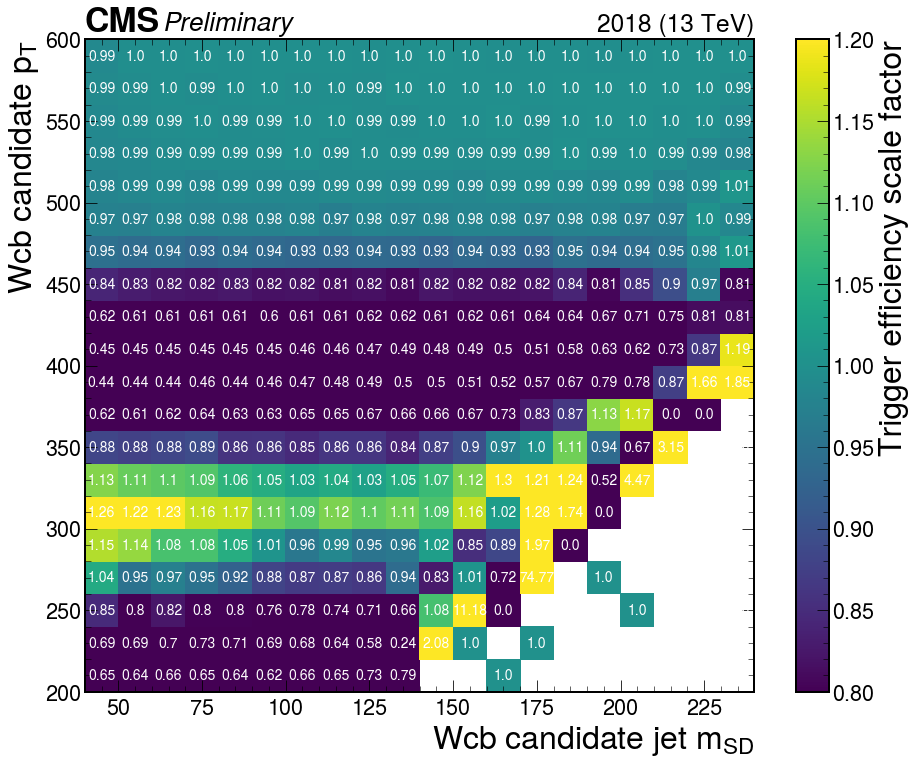

In [11]:
plot_effi_withvalue(eventsMC=events["QCD"], eventsData=events["SingleMuon"], x_label="Mja", y_label = "PTja", legend_location='lower right')

### (optional) plot the 2D trigger efficiency distributionm

In [ ]:
#Plot 2D trigger efficiency SFs.
def TriggerEff2D(eventsMC, x_label, y_label, isData = True, xmin = 200, xmax = 1200, bins = 500, legend_location='best'):
    if x_label == y_label: return
    """
    events: a dictionary, events.values() are collections of events
    """
    x_score, y_score = 'score_'+x_label, 'score_'+y_label
    # ax = plt.figure(figsize=(10,10))
    plt.figure(figsize=(15,12))
    ax=plt.gca()
    # fig ,ax = plt.subplots()
    hep.cms.label(data= isData, label = "Preliminary", year="2018", ax=ax, fontname='sans-serif')
    mmin = 40.0
    mmax = 240.0
    mbins = 20

    ptmin = 200.0
    ptmax = 600.0
    ptbins = 20

    if isData:
        eventsData = eventsMC

        hist2DData = bh.Histogram(bh.axis.Regular(mbins, mmin, mmax),bh.axis.Regular(ptbins, ptmin, ptmax),storage=bh.storage.Weight())
        hist2DData.fill(eventsData["Mj_V2_a"],eventsData["PTj_V2_a"])

        eventsData_Cut = eventsData[ (eventsData["HLT_PFJet500"] == True)  | (eventsData["HLT_AK8PFJet500"] == True) | (eventsData["HLT_PFHT1050"] == True)  | (eventsData["HLT_AK8PFJet400_TrimMass30"] == True) | (eventsData["HLT_AK8PFJet420_TrimMass30"] == True)  | (eventsData["HLT_AK8PFHT800_TrimMass50"] == True) | (eventsData["HLT_AK8PFHT850_TrimMass50"] == True) | (eventsData["HLT_AK8PFHT900_TrimMass50"] == True)]

        hist2DData_Cut = bh.Histogram(bh.axis.Regular(mbins, mmin, mmax),bh.axis.Regular(ptbins, ptmin, ptmax),storage=bh.storage.Weight())
        hist2DData_Cut.fill(eventsData_Cut["Mj_V2_a"],eventsData_Cut["PTj_V2_a"])

        Effi2D = hist2DData_Cut.view().value / hist2DData.view().value
        mesh = ax.pcolormesh(*hist2DData.axes.edges.T, Effi2D.T )
        
        xedges = hist2DData.axes[0].edges
        print(xedges)
        yedges = hist2DData.axes[1].edges
        print(yedges)
        h = Effi2D
        print(h)
        for i in range(len(xedges)-1):
            for j in range(len(yedges)-1):
                print(h[i,j])
                plt.text(xedges[i]+0.5*(xedges[i+1]-xedges[i]), yedges[j]+0.5*(yedges[j+1]-yedges[j]), round(h[i,j],2), color='white', ha='center', va='center',fontsize = 14)

        Namesup = "SingleMuon:"
        namestr = "./2DSFPlots_Updated_07052023/2018DataEffi2D" + y_label + "_vs_" + x_label + ".pdf"

    else:
   
        hist2DMC = bh.Histogram(bh.axis.Regular(mbins, mmin, mmax),bh.axis.Regular(ptbins, ptmin, ptmax),storage=bh.storage.Weight())
        hist2DMC.fill(eventsMC["Mj_V2_a"],eventsMC["PTj_V2_a"],weight = eventsMC["weight"])
    
        eventsMC_Cut = eventsMC[ (eventsMC["HLT_PFJet500"] == True) | (eventsMC["HLT_AK8PFJet500"] == True)  | (eventsMC["HLT_PFHT1050"] == True)  | (eventsMC["HLT_AK8PFJet400_TrimMass30"] == True) | (eventsMC["HLT_AK8PFJet420_TrimMass30"] == True) | (eventsMC["HLT_AK8PFHT800_TrimMass50"] == True) | (eventsMC["HLT_AK8PFHT850_TrimMass50"] == True) | (eventsMC["HLT_AK8PFHT900_TrimMass50"] == True)]
        
        hist2DMC_Cut = bh.Histogram(bh.axis.Regular(mbins, mmin, mmax),bh.axis.Regular(ptbins, ptmin, ptmax),storage=bh.storage.Weight())
        hist2DMC_Cut.fill(eventsMC_Cut["Mj_V2_a"],eventsMC_Cut["PTj_V2_a"],weight = eventsMC_Cut["weight"]*eventsMC_Cut["TriggerSF"])
    
        Effi2D = hist2DMC_Cut.view().value / hist2DMC.view().value
        mesh = ax.pcolormesh(*hist2DMC.axes.edges.T, Effi2D.T )
        
        xedges = hist2DMC.axes[0].edges
        print(xedges)
        yedges = hist2DMC.axes[1].edges
        print(yedges)
        h = Effi2D
        print(h)
        
        for i in range(len(xedges)-1):
            for j in range(len(yedges)-1):
                print(h[i,j])
                plt.text(xedges[i]+0.5*(xedges[i+1]-xedges[i]), yedges[j]+0.5*(yedges[j+1]-yedges[j]), round(h[i,j],2), color='white', ha='center', va='center',fontsize = 14)
       
        Namesup = "QCD:"
        namestr = "./2DSFPlots_Updated_07052023/2018QCDEffi2D" + y_label + "_vs_" + x_label + ".pdf"





    # plt.title('2D-Trigger Efficiency', fontsize=32,color="black", x = 0.3, y = 0.9)
    cbar = plt.colorbar(mesh)
    cbar.set_label('Trigger efficiency', rotation= 90,fontsize=32)
    plt.xlabel(Namesup + r"Higgs candidate jet $m_{SD}$", fontsize=20, ha='right', x=1)
    plt.ylabel(Namesup + r"Higgs candidate jet $p_{T}$", fontsize=20, ha='right', y=1)
    plt.savefig(namestr, bbox_inches='tight')

    plt.show()

In [ ]:
TriggerEff2D(eventsMC=events["SingleMuon"],isData = True,  x_label="Mja", y_label = "PTja",legend_location='lower right')


In [ ]:
TriggerEff2D(eventsMC=events["QCD"],isData = False,  x_label="Mja", y_label = "PTja",legend_location='lower right')
# TriggerEff2D(eventsMC=events["JetHT"],isData = True,  x_label="Mja", y_label = "PTja",legend_location='lower right')
